In [ ]:
# !pip install tensorflowjs --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 46.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import image_dataset_from_directory as IMFD
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0


In [4]:
SOURCE = '/content/drive/MyDrive/TasteTrip/Production/v2'

# Main dataset
DATASET_PATH = os.path.join(SOURCE, "raw_dataset")

# Split dataset
SPLIT_DATASET_PATH = os.path.join(SOURCE, "split_dataset_4_v2") # Use new dataset

TRAIN_PATH = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_PATH = os.path.join(SPLIT_DATASET_PATH, 'val')
TEST_PATH = os.path.join(SPLIT_DATASET_PATH, 'test')

# Food Categories
FOOD_LIST = sorted(os.listdir(TRAIN_PATH)) # Remember always to sort
NUM_OF_FOOD = len(FOOD_LIST)

print('Food total:', NUM_OF_FOOD)

print('\nFood category:', FOOD_LIST)

Food total: 10

Food category: ['ayam_goreng', 'bakso', 'bubur', 'gado_gado', 'mie_ayam', 'nasi_goreng', 'nasi_padang', 'rawon', 'sate_ayam', 'soto_ayam']


In [5]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]

  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]

    plt.xlabel(FOOD_LIST[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Generate Tensorflow Dataset

Using image_dataset_from_directory from keras.utils for easy data pipeline

In [6]:
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
BATCH_SIZE = 65 # | 64 | 32 | 16 |
IMAGE_SIZE = (384, 384)
SEED = 314

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [7]:
# Create train dataset
train_dataset = IMFD(
    TRAIN_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Create validation dataset
val_dataset = IMFD(
    VAL_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

test_dataset = IMFD(
    TEST_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

Found 1187 files belonging to 10 classes.
Found 219 files belonging to 10 classes.
Found 83 files belonging to 10 classes.


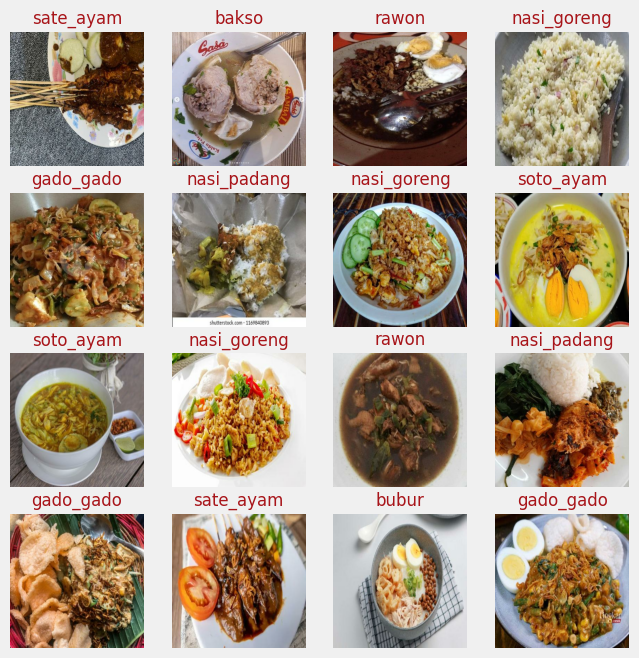

In [8]:
def plot_dataset_batch_images(data_generator, class_names):
    plt.figure(figsize=(8, 8))

    for images, labels in data_generator.take(1):
        for i in range(16):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Get the class index using one-hot encoding
            class_index = np.argmax(labels[i])

            # Display class name as title
            plt.title(class_names[class_index])
            plt.axis("off")

plot_dataset_batch_images(train_dataset, FOOD_LIST)

## Preprocessing Data

In [9]:
rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(
        (-0.1, 0.1),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
    tf.keras.layers.RandomTranslation(
        (-0.1, 0.1),
        (-0.1, 0.1),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
])

In [10]:
# Rescale
train_ds = train_dataset.map(lambda x, y: (rescale_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (rescale_layer(x), y))
test_ds = test_dataset.map(lambda x, y: (rescale_layer(x), y))

# Augment only train set
train_ds = train_ds.map(lambda x, y: (augmentation_layer(x), y))

In [11]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)


val_ds = val_ds.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_ds = test_ds.cache().prefetch(PREFETCH_BUFFER_SIZE)

## Building The Model

In [ ]:
input_shape = (384, 384, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    include_preprocessing=False
)

base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(620, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(320, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_OF_FOOD, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 384, 384, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 12, 12, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 620)                 │         794,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 620)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 320)                 │         198,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           3,210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,327,510 (81.36 MB)

 Trainable params: 996,150 (3.80 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

## Callbacks

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.92):
            print("\nReached desired accuracy, stopping training!")
            self.model.stop_training = True

In [13]:
def lr_scheduler(epoch, lr):
    init_lr = learning_rate
    decay_rate = 0.9
    decay_steps = 15

    lr = init_lr * (decay_rate ** (epoch // decay_steps))
    return lr

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/TasteTrip/Production/v2/best/dev_EfficientNetV2S_model.keras'

callbacks = [
    #myCallback(),
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=15,
                                     restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=False,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)
]

## Train the model

In [ ]:
EPOCHS = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.1220 - loss: 2.3637 - val_accuracy: 0.3973 - val_loss: 2.0579 - learning_rate: 1.0000e-04
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 718ms/step - accuracy: 0.2779 - loss: 2.0683 - val_accuracy: 0.4749 - val_loss: 1.8144 - learning_rate: 1.0000e-04
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 697ms/step - accuracy: 0.3882 - loss: 1.8676 - val_accuracy: 0.5936 - val_loss: 1.5726 - learning_rate: 1.0000e-04
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.4959 - loss: 1.6315 - val_accuracy: 0.6621 - val_loss: 1.3552 - learning_rate: 1.0000e-04
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 634ms/step - accuracy: 0.5141 - loss: 1.4971 - val_accuracy: 0.6667 - val_loss: 1.1646 - learning_rate: 1.0000e-04
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 656ms/step - accuracy: 0.6274 - loss: 1.2686 - val_accuracy: 0.7352 - val_loss: 0.9922 - learning_rate: 1.0000e-04
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step 

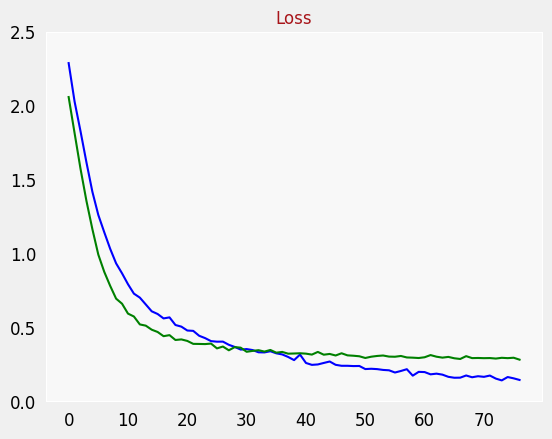

In [ ]:
plot_metrics("loss", "Loss", ylim=2.5)

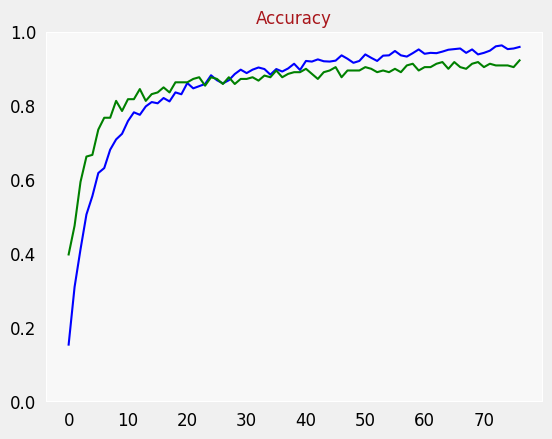

In [ ]:
plot_metrics("accuracy", "Accuracy", ylim=1)

In [ ]:
# model.save(os.path.join(SOURCE, 'models', ''))

## Model eval with test set

After train model test or for the existing model test

In [19]:
best_model = tf.keras.models.load_model("/content/drive/MyDrive/TasteTrip/Production/v2/best/dev_EfficientNetV2S_model.keras") #(the best model from checkpoint)
#best_model = model

In [20]:
# Quick evaluation
best_model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.9393 - loss: 0.2323


[0.23528841137886047, 0.9397590160369873]

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Predictions (y)
y_pred_probs = best_model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if len(y_true.shape) > 1:  # If one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Classification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.89      1.00      0.94         8
           2       0.80      0.89      0.84         9
           3       1.00      1.00      1.00         8
           4       1.00      0.89      0.94         9
           5       1.00      0.88      0.93         8
           6       1.00      0.88      0.93         8
           7       0.89      1.00      0.94         8
           8       1.00      1.00      1.00         8
           9       0.88      0.88      0.88         8

    accuracy                           0.94        83
   macro avg       0.95      0.94      0.94        83
weighted avg       0.94      0.94      0.94        83



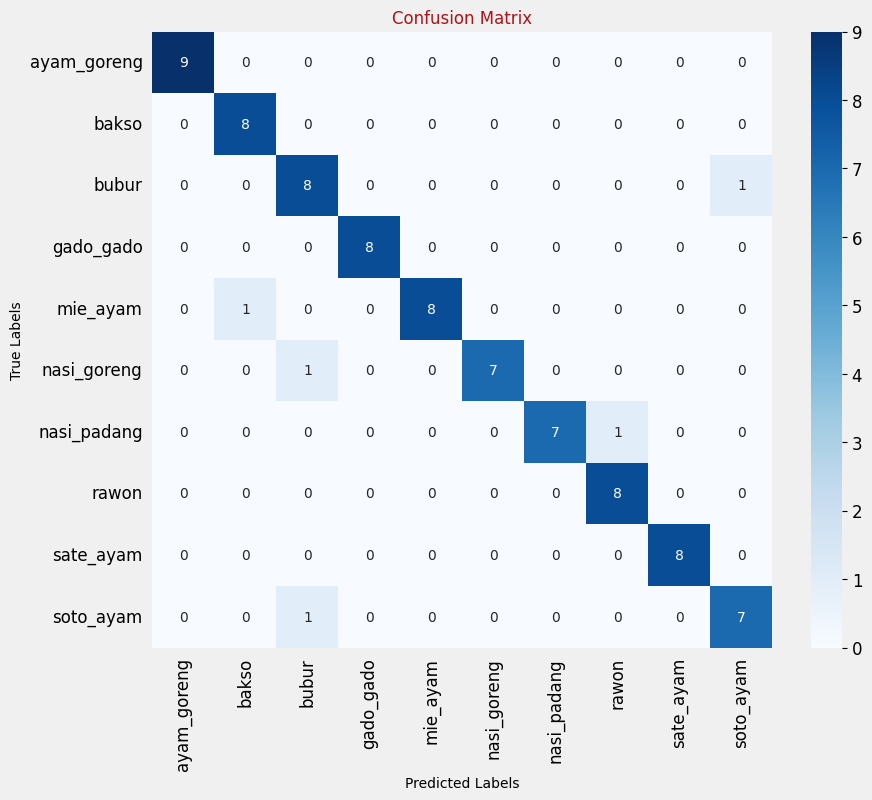

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=FOOD_LIST, yticklabels=FOOD_LIST)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

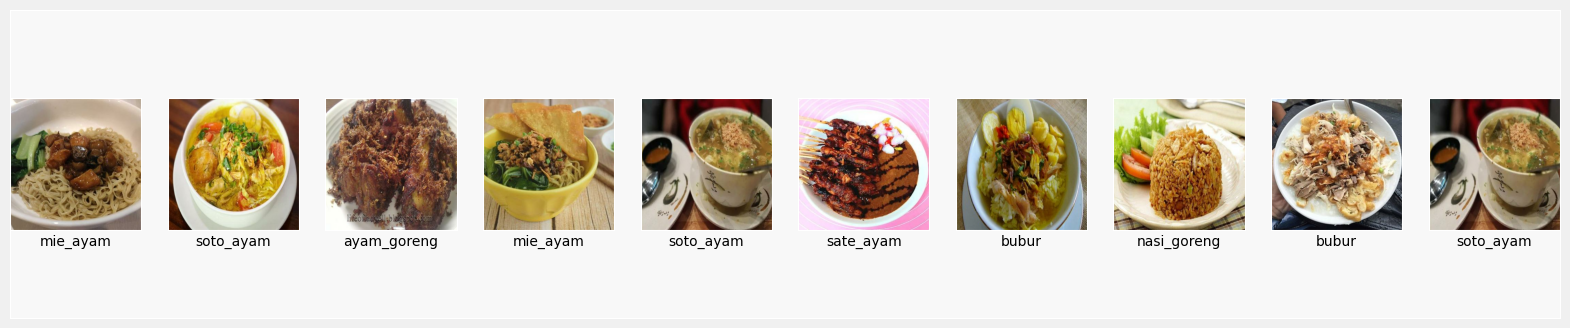

In [29]:
for images, labels in test_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    break

probabilities = best_model.predict(images, verbose=0)
predictions = tf.argmax(probabilities, axis=1).numpy()

display_images(images, predictions, labels, "")

## Model conversion

In [30]:
import tensorflowjs as tfjs

#model_path = tf.keras.models.load_model(checkpoint_filepath)
output_path = os.path.join(SOURCE, "dev_EfficientNetV2S_tfjs")

tfjs.converters.save_keras_model(best_model, './dev_EfficientNetV2S_tfjs')